In [71]:
import numpy as np
import tempfile
import imageio
import os
import sys

from scipy.integrate import odeint
from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection
from matplotlib.animation import FFMpegWriter
from matplotlib.patches import Circle
from matplotlib import animation

In [3]:
import sympy as smp

from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.solvers.solveset import linsolve

init_vprinting()

## Double Pendulum 

First, we write the Lagrangian and use the Euler-Lagrange equation to get equations of motion. ([These](https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid23.ipynb) [sources](https://scipython.com/blog/the-double-pendulum/) have been very helpful.)

In [4]:
# Create Symbols:
m1, m2 = smp.symbols("m1, m2")
l1, l2 = smp.symbols("l1, l2")

g = smp.Symbol('g')
t = smp.Symbol('t')  # Creates symbolic variable t
th1, th2 = dynamicsymbols('theta_1, theta_2')

# Position Equation: r = [x, y]
r1 = np.array([l1 * smp.sin(th1), -l1 * smp.cos(th1)])  # Position of first pendulum
r2 = np.array([l2 * smp.sin(th2) + r1[0], -l2 * smp.cos(th2) + r1[1]])  # Position of second pendulum

# Velocity Equation: d/dt(r) = [dx/dt, dy/dt]
v1 = np.array([r1[0].diff(t), r1[1].diff(t)])  # Velocity of first pendulum
v2 = np.array([r2[0].diff(t), r2[1].diff(t)])  # Velocity of second pendulum

# Energy Equations:
T = 1/2 * m1 * np.dot(v1, v1) + 1/2 * m2 * np.dot(v2, v2)  # Kinetic Energy
V = m1 * g * r1[1] + m2 * g * r2[1] # Potential Energy
L = T - V  # Lagrangian
E = T + V  # Total Energy

# Replace Time Derivatives and Functions with Symbolic Variables:
dth1, dth2 = th1.diff(t), th2.diff(t)
ddth1, ddth2 = dth1.diff(t), dth2.diff(t)

# Euler-Lagrange Equations
LE1 = (L.diff(dth1).diff(t) - L.diff(th1)).simplify()
LE2 = (L.diff(dth2).diff(t) - L.diff(th2)).simplify()


In [79]:
import sys
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Pendulum rod lengths (m), bob masses (kg).
L1, L2 = 1, 1
m1, m2 = 1, 1
# The gravitational acceleration (m.s-2).
g = 9.81

def deriv(y, t, L1, L2, m1, m2):
    """Return the first derivatives of y = theta1, z1, theta2, z2."""
    theta1, z1, theta2, z2 = y

    c, s = np.cos(theta1-theta2), np.sin(theta1-theta2)

    theta1dot = z1
    z1dot = (m2*g*np.sin(theta2)*c - m2*s*(L1*z1**2*c + L2*z2**2) -
             (m1+m2)*g*np.sin(theta1)) / L1 / (m1 + m2*s**2)
    theta2dot = z2
    z2dot = ((m1+m2)*(L1*z1**2*s - g*np.sin(theta2) + g*np.sin(theta1)*c) + 
             m2*L2*z2**2*s*c) / L2 / (m1 + m2*s**2)
    return theta1dot, z1dot, theta2dot, z2dot

def calc_E(y):
    """Return the total energy of the system."""

    th1, th1d, th2, th2d = y.T
    V = -(m1+m2)*L1*g*np.cos(th1) - m2*L2*g*np.cos(th2)
    T = 0.5*m1*(L1*th1d)**2 + 0.5*m2*((L1*th1d)**2 + (L2*th2d)**2 +
            2*L1*L2*th1d*th2d*np.cos(th1-th2))
    return T + V

# Maximum time, time point spacings and the time grid (all in s).
tmax, dt = 30, 0.01
t = np.arange(0, tmax+dt, dt)
# Initial conditions: theta1, dtheta1/dt, theta2, dtheta2/dt.
y0 = np.array([3*np.pi/7, 0, 3*np.pi/4, 0])

# Do the numerical integration of the equations of motion
y = odeint(deriv, y0, t, args=(L1, L2, m1, m2))

# Check that the calculation conserves total energy to within some tolerance.
EDRIFT = 0.05
# Total energy from the initial conditions
E = calc_E(y0)
print(E)
if np.max(np.sum(np.abs(calc_E(y) - E))) > EDRIFT:
    sys.exit('Maximum energy drift of {} exceeded.'.format(EDRIFT))

# Unpack z and theta as a function of time
theta1, theta2 = y[:,0], y[:,2]

# Convert to Cartesian coordinates of the two bob positions.
x1 = L1 * np.sin(theta1)
y1 = -L1 * np.cos(theta1)
x2 = x1 + L2 * np.sin(theta2)
y2 = y1 - L2 * np.cos(theta2)

# Plotted bob circle radius
r = 0.05
# Plot a trail of the m2 bob's position for the last trail_secs seconds.
trail_secs = 1
# This corresponds to max_trail time points.
max_trail = int(trail_secs / dt)

def make_plot(i):
    # Plot and save an image of the double pendulum configuration for time
    # point i.
    # The pendulum rods.
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k')
    # Circles representing the anchor point of rod 1, and bobs 1 and 2.
    c0 = Circle((0, 0), r/2, fc='k', zorder=10)
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10)
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10)
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # The trail will be divided into ns segments and plotted as a fading line.
    ns = 20
    s = max_trail // ns

    for j in range(ns):
        imin = i - (ns-j)*s
        if imin < 0:
            continue
        imax = imin + s + 1
        # The fading looks better if we square the fractional length along the
        # trail.
        alpha = (j/ns)**2
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Centre the image on the fixed anchor point, and ensure the axes are equal
    ax.set_xlim(-L1-L2-r, L1+L2+r)
    ax.set_ylim(-L1-L2-r, L1+L2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.savefig('frames/_img{:04d}.png'.format(i//di), dpi=72)
    plt.cla()


# Make an image every di time points, corresponding to a frame rate of fps
# frames per second.
# Frame rate, s-1
# fps = 10
# di = int(1/fps/dt)
# fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
# ax = fig.add_subplot(111)

# for i in range(0, t.size, di):
#     print(i // di, '/', t.size // di)
#     make_plot(i)

2.5708567992171414


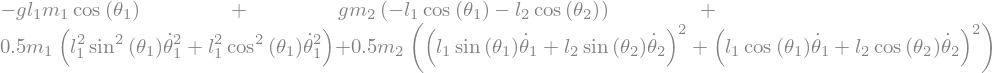

In [57]:
E

In [60]:
sols = smp.solve([LE1, LE2], (ddth1, ddth2), simplify=False, rational=False)

dz1_f = smp.lambdify((t,g,m1,m2,l1,l2,th1,th2,dth1,dth2), sols[ddth1])
dz2_f = smp.lambdify((t,g,m1,m2,l1,l2,th1,th2,dth1,dth2), sols[ddth2])
dth1_f = smp.lambdify(dth1, dth1)
dth2_f = smp.lambdify(dth2, dth2)
E_f = smp.lambdify((g,m1,m2,l1,l2,th1,dth1,th2,dth2), E)

In [70]:
for i in range(len(dp.ans)):
    E_f(9.8, 1, 1, 1, 1, *dp.ans[i])

In [66]:
dp.ans

array([[  1.        ,   1.5       ,  -1.        ,   5.        ],
       [  1.01340875,   1.18224878,  -0.95023467,   4.95338474],
       [  1.02365618,   0.86784737,  -0.900923  ,   4.90955571],
       ...,
       [ 20.12061724, -10.86631348,  26.43369392,   8.43295468],
       [ 20.01462516, -10.17830791,  26.51574452,   7.85616779],
       [ 19.91855554,  -9.02537675,  26.58961798,   6.90913122]])

In [69]:
len(dp.ans)

Because Python can only solve first-order ODE, we solve a system of four equations in terms of $\dot{\theta}_1, \dot{\theta}_2, \dot{z}_1, \dot{z}_2$, where $z_i = \dot{\theta}_i$.

In [105]:
class DoublePendulum:
    
    def __init__(self, m1, m2, l1, l2, state0, g=9.8):
        self.m1 = m1
        self.m2 = m2
        self.l1 = l1
        self.l2 = l2
        self.state0 = state0
        self.g = g  

    
    def run(self, t_max=30, dt=0.01):
        self.t_max = t_max
        self.dt = dt
        self.t = np.arange(0, self.t_max+self.dt, self.dt)
        
        ans = odeint(
            self.integrate,
            y0=self.state0, t=self.t,
            args=(self.g,self.m1,self.m2,self.l1,self.l2)
        )
        self.th1 = ans.T[0]
        self.th2 = ans.T[2]
        
        self.x1 = self.l1*np.sin(self.th1)
        self.y1 = -self.l1*np.cos(self.th1)
        self.x2 = self.x1 + self.l2*np.sin(self.th2)
        self.y2 = self.y1 - self.l2*np.cos(self.th2) 
        
        self._check_energy_drift(ans)
                

    def _check_energy_drift(self, ans, E_drift=0.05):
        E0 = E_f(self.g, self.m1, self.m2, self.l1, self.l2, *self.state0)
        for i in range(len(ans)):
            E1 = E_f(self.g, self.m1, self.m2, self.l1, self.l2, *ans[i])
            if np.abs(E0 - E1) / E0 > E_drift:
                sys.exit(f"Something's wrong! Maximum energy drift exceeded {E_drift}")
        
        
    def plot(self, filepath=None, fps=30, max_trail=100, ns=20): 
        r0 = 0.03
        r1 = 0.01 + np.clip(self.m1, 1, 10) * 0.05
        r2 = 0.01 + np.clip(self.m2, 1, 10) * 0.05
            
        fig = plt.figure(facecolor="w", figsize=(6.25 / 2, 6.25 / 2), dpi=100)
        ax = fig.add_subplot(111)
        
        ax.set_axis_off()
        ax.set_xlim(-self.l1-self.l2-max(r1, r2), self.l1+self.l2+max(r1, r2))
        ax.set_ylim(-self.l1-self.l2-max(r1, r2), self.l1+self.l2+max(r1, r2))
        ax.set_aspect('equal', adjustable='box')
        
        self.rods, = ax.plot([], [], lw=1, c='k')
        self.trail = [ax.plot([], [], lw=1, c='r', alpha=0, solid_capstyle='butt')[0]
                      for _ in range(ns)]
        
        self.c0 = Circle((0, 0), r0/2, fc='k', zorder=10)
        self.c1 = Circle((0, 0), r1, fc='b', ec='b', zorder=10)
        self.c2 = Circle((0, 0), r2, fc='r', ec='r', zorder=10) 
        
        ax.add_patch(self.c0)
        ax.add_patch(self.c1)
        ax.add_patch(self.c2)
        
        fig.tight_layout()
        frames = tqdm(range(0, self.t.size, 1), leave=False)
        ani = animation.FuncAnimation(
            fig, self._animate, frames=frames,
            fargs=(max_trail,ns), interval=self.dt*1000/2
        )
        
        if filepath:
            ani.save('test.gif',writer='pillow',fps=0.5*1/self.dt, dpi=150)                        
            
    
    def _animate(self, i, max_trail, ns):
        self.c1.center = (self.x1[i], self.y1[i])
        self.c2.center = (self.x2[i], self.y2[i])
        self.rods.set_data(
            [0, self.x1[i], self.x2[i]],
            [0, self.y1[i], self.y2[i]]
        )
        
        s = max_trail // ns
        for j in range(ns):
            imin = max(i - (ns-j)*s, 0)
            imax = imin + s + 1
                    
            alpha = (j/ns)**3
            self.trail[j].set_data(self.x2[imin:imax], self.y2[imin:imax])
            self.trail[j].set_alpha(alpha)
        
        
    @staticmethod
    def integrate(state, t, g, m1, m2, l1, l2):
        th1, z1, th2, z2 = state
        return [
            dth1_f(z1),
            dz1_f(t, g, m1, m2, l1, l2, th1, th2, z1, z2),
            dth2_f(z2),
            dz2_f(t, g, m1, m2, l1, l2, th1, th2, z1, z2),
        ]
    

<IPython.core.display.Javascript object>


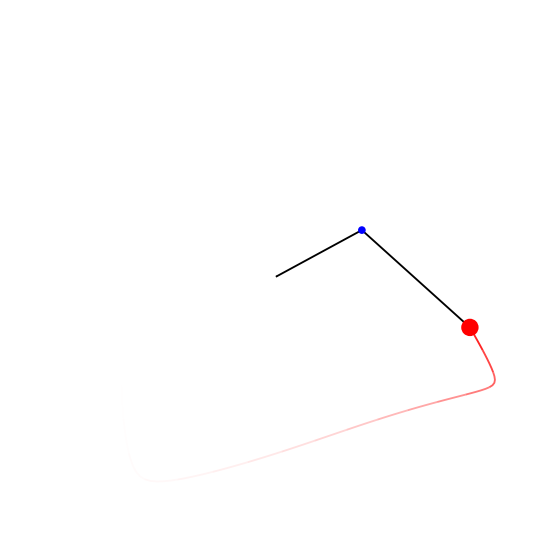

  0%|          | 0/1001 [00:00<?, ?it/s]

In [106]:
%matplotlib notebook

dp = DoublePendulum(1, 3, 2, 3, state0=[1, 1.5, -1, 5])
dp.run(t_max=10)
# dp.plot("test.gif")
dp.plot()

## Triple pendulum

In [ ]:
# Create Symbols:
m1, m2, m3 = smp.symbols("m1, m2, m3")
l1, l2, l3 = smp.symbols("l1, l2, l3")

g = smp.Symbol('g')
t = smp.Symbol('t')  # Creates symbolic variable t
th1, th2, th3 = dynamicsymbols('theta_1, theta_2, theta_3')

# Position Equation: r = [x, y]
r1 = np.array([l1 * smp.sin(th1), -l1 * smp.cos(th1)])  # Position of first pendulum
r2 = np.array([l2 * smp.sin(th2) + r1[0], -l2 * smp.cos(th2) + r1[1]])  # Position of second pendulum

# Velocity Equation: d/dt(r) = [dx/dt, dy/dt]
v1 = np.array([r1[0].diff(t), r1[1].diff(t)])  # Velocity of first pendulum
v2 = np.array([r2[0].diff(t), r2[1].diff(t)])  # Velocity of second pendulum

# Energy Equations:
T = 1/2 * m1 * np.dot(v1, v1) + 1/2 * m2 * np.dot(v2, v2)  # Kinetic Energy
V = m1 * g * r1[1] + m2 * g * r2[1] # Potential Energy
L = T - V  # Lagrangian
E = T + V  # Total Energy

# Replace Time Derivatives and Functions with Symbolic Variables:
dth1, dth2 = th1.diff(t), th2.diff(t)
ddth1, ddth2 = dth1.diff(t), dth2.diff(t)

# Euler-Lagrange Equations
LE1 = (L.diff(dth1).diff(t) - L.diff(th1)).simplify()
LE2 = (L.diff(dth2).diff(t) - L.diff(th2)).simplify()
